In [1]:
# Library imports

"""

# Trying to make a "jump to cell" link to the next cell

import jupyter

jupyter.execute_cells([19])
"""

# Read dataset
import pandas as pd

# Check path
import os

import tensorflow as tf

# Text vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#  Incarcam setul de date
file_path = 'News_Category_Dataset_v3.json'
if not os.path.exists(file_path):
    print(f"Eroare: Fisierul {file_path} nu a fost gasit.")

# Citim setul de date
data = pd.read_json(file_path, lines=True)

In [3]:
# Debug incarcare dataset
print(data.head(3), "\n\n")


                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog you don't understand wha...         Elyse Wanshel   

        date  
0 2022-09-23  
1 2022-09-23  
2 2022-09-23   




In [4]:
# Prelucrare dataset

# Textul stirii este compus din titlu si descrierea sumara
data['text'] = data['headline'] + " " + data['short_description']

# Modelul se va folosi doar de textul final si categoria stirii respective
data = data[['text', 'category']]

# Valorile nule sunt eliminate
data = data.dropna()


                                                text   category
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY
3  The Funniest Tweets From Parents This Week (Se...  PARENTING
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS
5  Cleaner Was Dead In Belk Bathroom For 4 Days B...  U.S. NEWS 




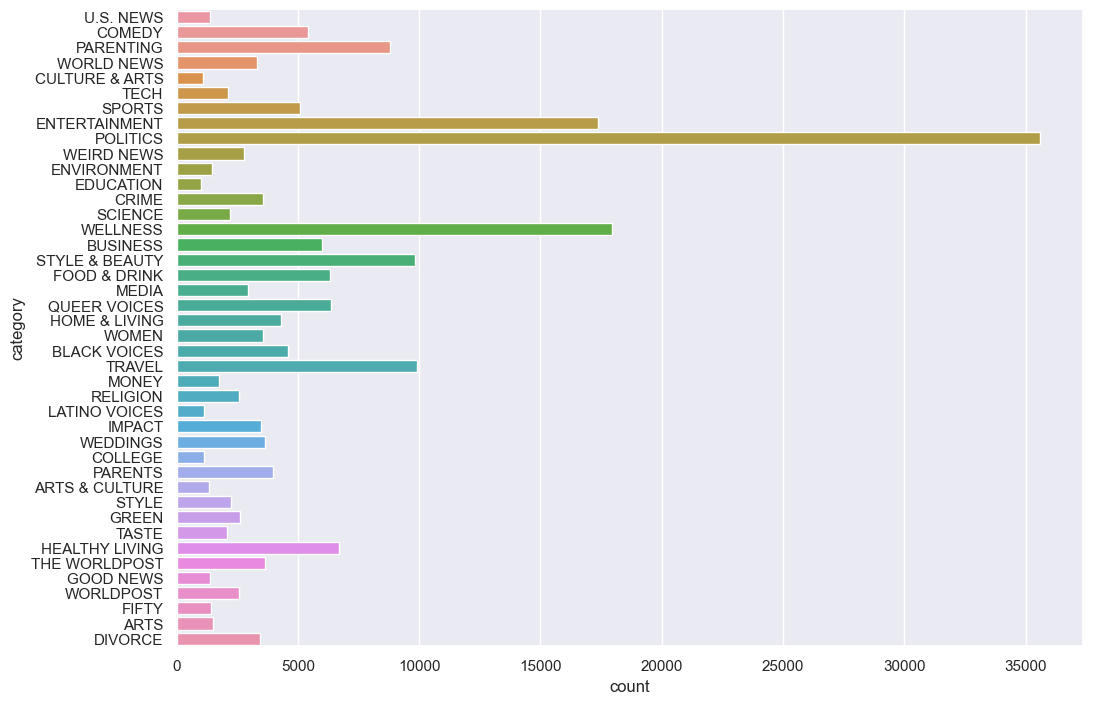

In [5]:
# Debug dataset prelucrat
print(data.head(6), "\n\n")

# Reprezentare grafica a datasetului
sns.set_theme(style="darkgrid", rc={'figure.figsize':(11.7,8.27)})
ax = sns.countplot(y="category", data=data)

In [6]:
# Vectorizare text
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)  # Limităm la 10.000 de termeni
X = vectorizer.fit_transform(data['text'])

# Conversie categorii în valori numerice
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['category'])

# Impartire dataset in set de antrenare si set de testare
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Conversie etichete - one-hot encoding
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [17]:

# Creare model - 3 straturi, regularizare L2
model = Sequential([
    Dense(256, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'), 
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.5), 
    Dense(y_train_categorical.shape[1], activation='softmax')
])

# Compilare model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'auc'])

'''
model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=len(label_encoder.classes_)
)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
'''

# Sumar model
model.summary()

C:\Users\arman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │     2,560,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 42)             │         1,386 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,604,874 (9.94 MB)

 Trainable params: 2,604,874 (9.94 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Callback-uri in caz de stagnare, pentru a preveni overfitting-ul
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)


In [9]:
'''
# Incarcare model preantrenat

model = tf.keras.models.load_model('Proiect_TIA.keras')
'''

"\n# Incarcare model preantrenat\n\nmodel = tf.keras.models.load_model('Proiect_TIA.keras')\n"

In [18]:

# Antrenare

history = model.fit(
    X_train,
    y_train_categorical,
    epochs=10,
    batch_size=80,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
1677/1677 ━━━━━━━━━━━━━━━━━━━━ 49s 28ms/step - accuracy: 0.2090 - auc: 0.7616 - loss: 3.5004 - precision: 0.7295 - recall: 0.0629 - val_accuracy: 0.3529 - val_auc: 0.8719 - val_loss: 2.9071 - val_precision: 0.8095 - val_recall: 0.1442 - learning_rate: 0.0010
Epoch 2/10
1677/1677 ━━━━━━━━━━━━━━━━━━━━ 49s 29ms/step - accuracy: 0.3522 - auc: 0.8676 - loss: 2.9605 - precision: 0.7534 - recall: 0.1461 - val_accuracy: 0.4194 - val_auc: 0.8950 - val_loss: 2.7083 - val_precision: 0.7983 - val_recall: 0.1962 - learning_rate: 0.0010
Epoch 3/10
1677/1677 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - accuracy: 0.3995 - auc: 0.8867 - loss: 2.7914 - precision: 0.7573 - recall: 0.1872 - val_accuracy: 0.4367 - val_auc: 0.9055 - val_loss: 2.5712 - val_precision: 0.7790 - val_recall: 0.2325 - learning_rate: 0.0010
Epoch 4/10
1677/1677 ━━━━━━━━━━━━━━━━━━━━ 44s 26ms/step - accuracy: 0.4216 - auc: 0.8962 - loss: 2.6783 - precision: 0.7526 - recall: 0.2116 - val_accuracy: 0.4547 - val_auc: 0.9124 - val_lo

In [11]:
# Evaluare pe setul de testare
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test_categorical)
print(f"Acuratete pe setul de testare: {accuracy:.2f}")

1310/1310 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1691 - auc: 0.7487 - loss: 3.2822 - precision: 0.0000e+00 - recall: 0.0000e+00
Acuratete pe setul de testare: 0.17


In [12]:
score = model.evaluate(X_test, y_test_categorical, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 3.2831406593322754
Test accuracy: 0.1707392781972885


In [13]:
# Testare model antrenat pe texte predefinite
text_test = [
    "The stock market is down due to the pandemic.",
    "A building caught on fire in the city center.",
    "The government unveils a new economic policy.",
    "A famous actor wins an award at the international film festival.",
    "A new study reveals the benefits of meditation.",
    "A new restaurant opens in the downtown area.",
    "The local team wins the championship game.",
    "A new technology is changing the way we communicate.",
    "A new law is passed to protect the environment.",
    "A new exhibit opens at the art museum.",
]

# Vectorizare texte
text_vectorized = vectorizer.transform(text_test)

# Prezicem categoriile
prediction = model.predict(text_vectorized)

# Convert
for text, category in zip(text_test, prediction):
    predict_category = label_encoder.inverse_transform([category.argmax()])[0]
    print(f"Text: {text}")
    print(f"Predictie categorie: {predict_category}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Text: The stock market is down due to the pandemic.
Predictie categorie: POLITICS

Text: A building caught on fire in the city center.
Predictie categorie: POLITICS

Text: The government unveils a new economic policy.
Predictie categorie: POLITICS

Text: A famous actor wins an award at the international film festival.
Predictie categorie: POLITICS

Text: A new study reveals the benefits of meditation.
Predictie categorie: POLITICS

Text: A new restaurant opens in the downtown area.
Predictie categorie: POLITICS

Text: The local team wins the championship game.
Predictie categorie: POLITICS

Text: A new technology is changing the way we communicate.
Predictie categorie: POLITICS

Text: A new law is passed to protect the environment.
Predictie categorie: POLITICS

Text: A new exhibit opens at the art museum.
Predictie categorie: POLITICS



In [14]:
'''
# Testare pe un input de la tastatura

text_test = str(input())
text_vectorized = vectorizer.transform([text_test])
prediction = model.predict(text_vectorized)

for text, category in zip([text_test], prediction):
    predict_category = label_encoder.inverse_transform([category.argmax()])[0]
    print(f"Text: {text}")
    print(f"Predictie categorie: {predict_category}\n")
    '''


'\n# Testare pe un input de la tastatura\n\ntext_test = str(input())\ntext_vectorized = vectorizer.transform([text_test])\nprediction = model.predict(text_vectorized)\n\nfor text, category in zip([text_test], prediction):\n    predict_category = label_encoder.inverse_transform([category.argmax()])[0]\n    print(f"Text: {text}")\n    print(f"Predictie categorie: {predict_category}\n")\n    '

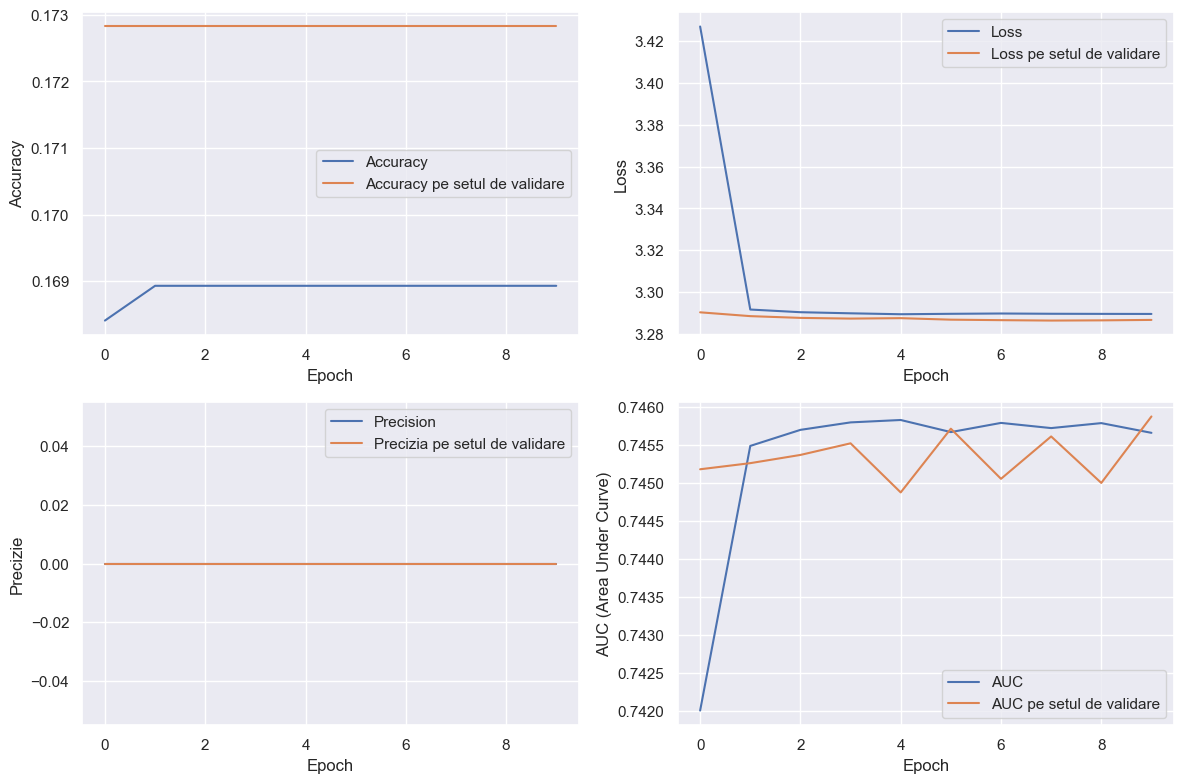

In [15]:
# Grafice model
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Accuracy pe setul de validare')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Loss pe setul de validare')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Precision')
plt.plot(history.history['val_precision'], label='Precizia pe setul de validare')
plt.xlabel('Epoch')
plt.ylabel('Precizie')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history.history['auc'], label='AUC')
plt.plot(history.history['val_auc'], label='AUC pe setul de validare')
plt.xlabel('Epoch')
plt.ylabel('AUC (Area Under Curve)')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
## Salvare model

model.save('Proiect_TIA.keras')